In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
## Imports
import numpy as np
import os
import sys
import pennylane as qml
from pennylane import numpy as pnp
import torch
import torch.nn as nn

## Imports
import os
import sys
import matplotlib

import shutil
import matplotlib.pyplot as plt

In [4]:

from src.utils.logger import Logging
from src.poisson.dv_solver import DVPDESolver
from src.poisson.cv_solver import CVPDESolver
from src.nn.pde import diffusion_operator
from src.utils.plot_prediction import plt_prediction
from src.data.diffusion_dataset import u, r
import src.poisson.diffusion_train as diffusion_train
from src.poisson.classical_solver import Classical_Solver
from src.data.diffusion_dataset import Sampler
from src.utils.cavity_plot_contour import ContourPlotter


os.environ['CUDA_VISIBLE_DEVICES'] = '-1'    # for no GPUs


In [ ]:
log_path = "./testing_checkpoints"
logger = Logging(log_path)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.cuda.is_available()

## Generate Testing Dataset


In [ ]:
NUM_OF_POINTS = 10

dom_coords = torch.tensor(
    [[0.0, 0.0, 0.0], [1.0, 1.0, 1.0]], dtype=torch.float32, device="cpu"
)

time_ = (
    torch.linspace(dom_coords[0, 0], dom_coords[1, 0], NUM_OF_POINTS)
    .to("cpu")
    .unsqueeze(1)
    .to(torch.float32)
)
xfa = (
    torch.linspace(dom_coords[0, 1], dom_coords[1, 1], NUM_OF_POINTS)
    .to("cpu")
    .unsqueeze(1)
    .to(torch.float32)
)

yfa = (
    torch.linspace(dom_coords[0, 2], dom_coords[1, 2], NUM_OF_POINTS)
    .to("cpu")
    .unsqueeze(1)
    .to(torch.float32)
)

time_, xfa, yfa = torch.meshgrid(time_.squeeze(), xfa.squeeze(), yfa.squeeze())
X_star = torch.hstack(
    (
        time_.flatten().unsqueeze(1),
        xfa.flatten().unsqueeze(1),
        yfa.flatten().unsqueeze(1),
    )
).to("cpu")



# Load trained model


In [ ]:
model_path = (
    "./models/2025-02-25_17-03-12-608017"  # circ_19
)

In [ ]:
data = X_star
solver = "DV"

if solver == "CV":
    state = CVPDESolver.load_state(os.path.join(model_path, "model.pth"))
    model = CVPDESolver(state["args"], logger, data, DEVICE)

    model.preprocessor.load_state_dict(state["preprocessor"])
    model.quantum_layer.load_state_dict(state["quantum_layer"])
    model.postprocessor.load_state_dict(state["postprocessor"])
else:
    state = DVPDESolver.load_state(os.path.join(model_path, "model.pth"))
    model = DVPDESolver(state["args"], logger, data, DEVICE)
    model.preprocessor.load_state_dict(state["preprocessor"])
    model.postprocessor.load_state_dict(state["postprocessor"])
    model.quantum_layer.load_state_dict(state["quantum_layer"])


model.logger = logger
model.logger.print(f"The settings used: {model.args}")
for key, value in model.args.items():
    model.logger.print(f"{key} : {value}")

model.logger.print(f"Totoal number of iterations : {len(state['loss_history'])}")
model.logger.print(f"The final loss : {state['loss_history'][-1]}")

model.loss_history = state["loss_history"]
model.model_path = logger.get_output_dir()


# Print total number of parameters
total_params = sum(p.numel() for p in model.parameters())
model.logger.print(f"Total number of parameters: {total_params}")
shutil.copytree(model_path, os.path.join(logger.get_output_dir(), model_path.split('/')[-1]), dirs_exist_ok=True)


In [ ]:
n = 5000  # Number of last iterations to plot
plt.plot(range(len(model.loss_history[-n:])), model.loss_history[-n:])
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid()

file_path = os.path.join(model.log_path, "loss_history.pdf")
plt.savefig(file_path, bbox_inches="tight")
plt.show()

plt.close(
    "all",
)

In [ ]:

u_pred, f_pred = diffusion_operator(
    model, X_star[:, 0:1], X_star[:, 1:2], X_star[:, 2:3]
)
if u_pred.is_cuda:
    u_pred = u_pred.cpu()
    f_pred = f_pred.cpu()


u_pred = u_pred.detach().numpy()
f_pred = f_pred.detach().numpy()

# Exact solution
u_analytic = u(X_star).cpu().detach().numpy()
f_analytic = r(X_star).cpu().detach().numpy()

error_u = (
    np.linalg.norm(u_analytic - u_pred, 2) / np.linalg.norm(u_analytic, 2)
) * 100.0
error_f = (
    np.linalg.norm(f_analytic - f_pred, 2) / np.linalg.norm(f_analytic + 1e-9, 2)
) * 100.0

logger.print("Relative L2 error_u: {:.2e}".format(error_u))
logger.print("Relative L2 error_f: {:.2e}".format(error_f))


In [ ]:
tstep = NUM_OF_POINTS
xstep = NUM_OF_POINTS
ystep = NUM_OF_POINTS


X = X_star.cpu().detach().numpy()
exact_velocity = u_analytic
exact_force = f_analytic


xf = xfa.reshape(tstep, xstep, ystep).cpu().detach().numpy()  # .reshape(100,100)[0,:]
yf = yfa.reshape(tstep, xstep, ystep).cpu().detach().numpy()  # .reshape(100,100)[:,0]

exact_velocity = exact_velocity.reshape(tstep, xstep, ystep)  # .reshape(100,100)[0,:]
exact_force = exact_force.reshape(tstep, xstep, ystep)  # .reshape(100,100)[0,:]

grbf_velocity = u_pred.reshape(tstep, xstep, ystep)  # .reshape(100,100)[0,:]
grbf_force = f_pred.reshape(tstep, xstep, ystep)  # .reshape(100,100)[0,:]


In [ ]:

# Visualize results
titles = [
    "exact_u",
    "exact_p",
    "pred_u_classic",
    "pred_p_classic",
"abs_error_u_classic",
    "abs_error_p_classic",

]

nrows_ncols = (3, 2)
values = [99]
xref = 1
yref = 1
model_dirname = model.log_path
img_width = 10
img_height = 10
ticks = 3
fontsize = 7
labelsize = 7
axes_pad = 0.5

visualization_data = [
   exact_velocity,                  # exact_u
    exact_force,                  # exact_p
    grbf_velocity,              # u_pred_classic
    grbf_force,              # p_pred_classic
    np.abs(exact_velocity - grbf_velocity),        # error_u_classic
     np.abs(exact_force - grbf_force),        # error_p_classic
]

plotter = ContourPlotter(fontsize=7, labelsize=7, axes_pad=0.5)

plotter.draw_contourf_regular_2D(
    time_[:, 0, 0],
    xf[0, :, 0],
    yf[0, 0, :],
    visualization_data,
    titles=titles,
    nrows_ncols=nrows_ncols,
    time_steps=[10],
    xref=1,
    yref=1,
    model_dirname=model_dirname,
    img_width=10,
    img_height=10,
    ticks=3,    
)


In [1]:
%load_ext autoreload
%autoreload 2

### OR Simply call the python script
```bash
python -m src.contour_plots.diffusion_hybrid_plotting
```

/okyanus/users/afarea/anaconda3_2021/envs/pennylane_env/lib/python3.9/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 8000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
/okyanus/users/afarea/anaconda3_2021/envs/pennylane_env/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
INFO:src.utils.logger:checkpoint path: self.log_path='testing_ch

Model state loaded from /okyanus/users/afarea/afrah/code/QNN4PDEs/log_files/checkpoints/diffusion/2025-02-25_17-03-12-608017/model.pth


INFO:src.utils.logger:Using DV Solver
INFO:src.utils.logger:Total number of iterations : 20001
INFO:src.utils.logger:The final loss : 0.005991735029965639
INFO:src.utils.logger:The circuit used in the study:


Model state loaded from /okyanus/users/afarea/afrah/code/QNN4PDEs/log_files/checkpoints/diffusion/2025-02-21_12-00-52-045180/model.pth
The circuit is saved in testing_checkpoints/diffusion/2025-03-03_22-10-29-248729


INFO:src.utils.logger:Relative L2 error_u: 1.33e+01
INFO:src.utils.logger:Relative L2 error_f: 3.34e+00
INFO:src.utils.logger:Total number of parameters: 821


inside else title:  Exact solution $u(x)$
inside else title:  PINN prediction $\hat{u}(x)$
inside if error title:  PINN error
inside else title:  QCPINN prediction $\hat{u}(x)$
inside if error title:  QCPINN error
inside else title:  Exact solution $f(x)$
inside else title:  PINN prediction $\hat{f}(x)$
inside if error title:  PINN error
inside else title:  QCPINN prediction $\hat{f}(x)$
inside if error title:  QCPINN error


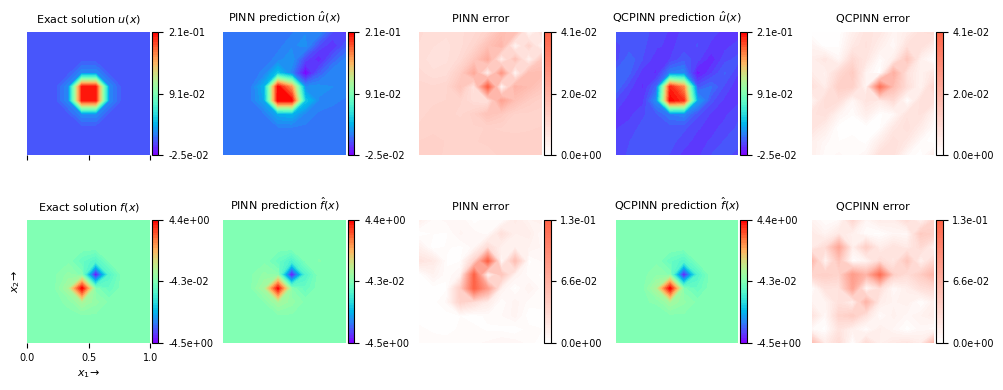


Loss values at iteration 12500:
----------------------------------------
classical           : 0.011826
angle_cascade       : 0.004480
----------------------------------------


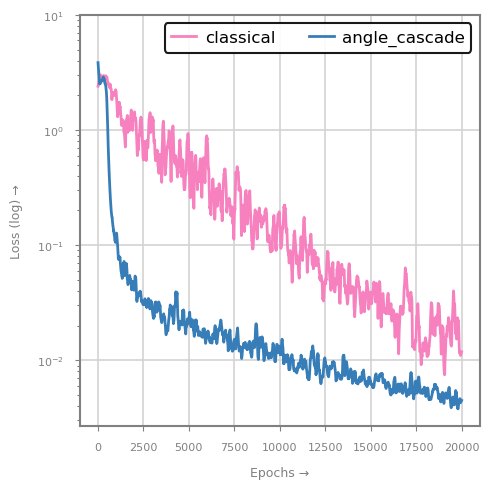

In [2]:
run -m src.contour_plots.diffusion_hybrid_plotting